# Segmenting and Clustering Neighborhoods in Toronto

- Using Julia to perform web scraping and create DataFrame
- Calling folium and other Python libraries via PyCall

In [35]:
using HTTP, JSON3
using DataFrames, CSV
using Plots, PlotThemes
using Pkg, PyCall, Conda

In [36]:
using OpenStreetMapX
using OpenStreetMapXPlot
using ScikitLearn
using Cascadia, Gumbo
using Clustering

In [37]:
flm = pyimport("folium")
mpl_cm = pyimport("matplotlib.cm")
mpl_colors = pyimport("matplotlib.colors")
cmap = mpl_cm.get_cmap("prism")

## Scraping Toronto Postcode Table

In [38]:
# Set our url for M postal codes in Toronto
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

"https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [39]:
# Grab the page
res = HTTP.get(url);

In [40]:
# Parse into HTML
body = String(res.body)
html = parsehtml(body)
table = eachmatch(sel".wikitable", html.root)[1]
trows = table.children[1].children

181-element Array{HTMLNode,1}:
 HTMLElement{:tr}:<tr>
  <th>
    Postal Code
  </th>
  <th>
    District
  </th>
  <th>
    Neighbourhood
  </th>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M1A
  </td>
  <td>
    Not assigned
  </td>
  <td>
    Not assigned
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M2A
  </td>
  <td>
    Not assigned
  </td>
  <td>
    Not assigned
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M3A
  </td>
  <td>
    North York
  </td>
  <td>
    Parkwoods
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M4A
  </td>
  <td>
    North York
  </td>
  <td>
    Victoria Village
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M5A
  </td>
  <td>
    Downtown Toronto
  </td>
  <td>
    Regent Park, Harbourfront
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M6A
  </td>
  <td>
    North York
  </td>
  <td>
    Lawrence Manor, Lawrence Heights
  </td>
</tr>


 HTMLElement{:tr}:<tr>
  <td>
    M7A
  </td>
  <td>
    Downtown Toronto
  </td>
  <td>
    Queen's Park,

In [41]:
# Extract header
header = trows[1]
colnames = []
for col in header.children
    push!(colnames, chomp(col.children[1].text))
end

In [42]:
# Extract table data
postcodes = []
boroughs = []
neighborhoods = []

for row in trows[2:end]
    push!(postcodes, chomp(row.children[1].children[1].text))
    push!(boroughs, chomp(row.children[2].children[1].text))
    push!(neighborhoods, chomp(row.children[3].children[1].text))
end

In [43]:
# Create DataFrame, filter out unassigned boroughs
df = DataFrame(
    colnames[1] => postcodes, 
    colnames[2] => boroughs, 
    colnames[3] => neighborhoods
)
df = df[df[:District] .≠ "Not assigned", :]

,Postal Code,District,Neighbourhood
,Any,Any,Any
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
6,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
7,M1B,Scarborough,"Malvern, Rouge"
8,M3B,North York,Don Mills
9,M4B,East York,"Parkview Hill, Woodbine Gardens"


In [44]:
# Print dataframe dimensions
size(df)

(103, 3)

## Adding Geocoding data


In [45]:
geo_df = CSV.read("./Geospatial_Coordinates.csv")

,Postal Code,Latitude,Longitude
,String,Float64,Float64
1,M1B,43.8067,-79.1944
2,M1C,43.7845,-79.1605
3,M1E,43.7636,-79.1887
4,M1G,43.771,-79.2169
5,M1H,43.7731,-79.2395
6,M1J,43.7447,-79.2395
7,M1K,43.7279,-79.262
8,M1L,43.7111,-79.2846
9,M1M,43.7163,-79.2395


In [46]:
# Join dataframes
latlong_df = leftjoin(df, geo_df, on="Postal Code")

,Postal Code,District,Neighbourhood
,Any,Any,Any
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
6,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
7,M1B,Scarborough,"Malvern, Rouge"
8,M3B,North York,Don Mills
9,M4B,East York,"Parkview Hill, Woodbine Gardens"


In [47]:
# Just Toronto
toronto_df = latlong_df[occursin.(r"Toronto", latlong_df[:District]), :]
unique(toronto_df[:District])
unique(toronto_df[:Neighbourhood])

39-element Array{Any,1}:
 "Regent Park, Harbourfront"
 "Queen's Park, Ontario Provincial Government"
 "Garden District, Ryerson"
 "St. James Town"
 "The Beaches"
 "Berczy Park"
 "Central Bay Street"
 "Christie"
 "Richmond, Adelaide, King"
 "Dufferin, Dovercourt Village"
 "Harbourfront East, Union Station, Toronto Islands"
 "Little Portugal, Trinity"
 "The Danforth West, Riverdale"
 ⋮
 "University of Toronto, Harbord"
 "Runnymede, Swansea"
 "Moore Park, Summerhill East"
 "Kensington Market, Chinatown, Grange Park"
 "Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park"
 "CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport"
 "Rosedale"
 "Stn A PO Boxes"
 "St. James Town, Cabbagetown"
 "First Canadian Place, Underground city"
 "Church and Wellesley"
 "Business reply mail Processing Centre, South Central Letter Processing Plant Toronto"

## Clustering Neighborhoods

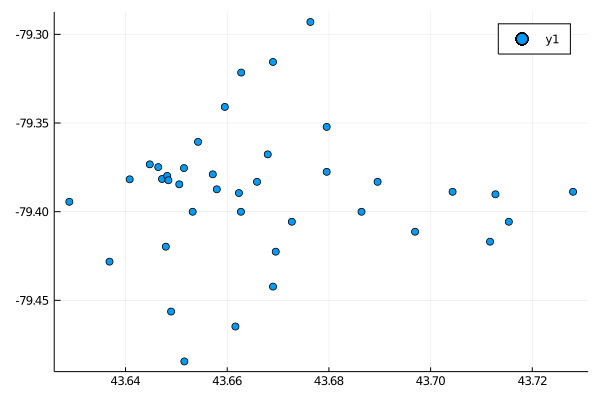

In [48]:
scatter(toronto_df[:Latitude], toronto_df[:Longitude])

In [49]:
# Transform into matrix, permute dimensions
toronto_matrix = convert(Matrix, toronto_df)
toronto_matrix_reshaped = permutedims(convert(Matrix{Float64}, toronto_matrix[:, 4:5]), [2, 1])

2×39 Array{Float64,2}:
  43.6543   43.6623   43.6572   43.6515  …   43.6484   43.6659   43.6627
 -79.3606  -79.3895  -79.3789  -79.3754     -79.3823  -79.3832  -79.3216

In [50]:
results = kmeans(toronto_matrix_reshaped, 4)

KmeansResult{Array{Float64,2},Float64,Int64}([43.65476389999999 43.66943648 43.655065657142856 43.70563855; -79.38308286842104 -79.32465436 -79.44547175714285 -79.39811351249999], [1, 1, 1, 1, 2, 1, 1, 3, 1, 3  …  4, 1, 4, 1, 1, 1, 1, 1, 1, 2], [0.0005041204058215953, 9.791545744519681e-5, 2.2937321773497388e-5, 6.944464257685468e-5, 0.0010479233824298717, 0.00019544138194760308, 2.865422356990166e-5, 0.0007343435863731429, 1.9782866729656234e-5, 0.00020462795146158896  …  0.000481670653243782, 0.000290287789539434, 0.00037339596383390017, 0.0007950561011966784, 0.0006458165298681706, 0.00013721324285143055, 0.0004117150128877256, 4.077269841218367e-5, 0.00012312714898143895, 5.437807340058498e-5], [19, 5, 7, 8], [19, 5, 7, 8], 0.01410524135644664, 5, true)

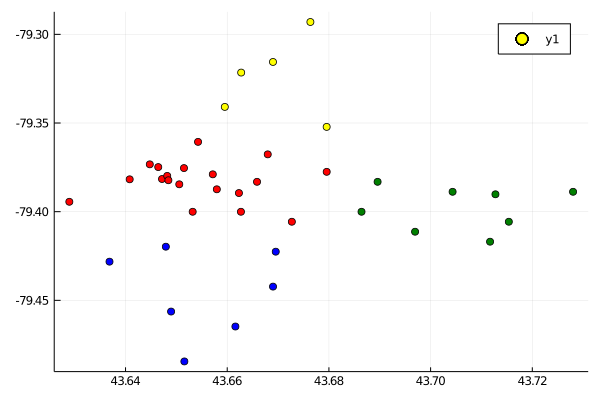

In [51]:
# Clusters based on number of Boroughs

colors = ["red" "yellow" "blue" "green"]
scatter(toronto_df[:Latitude], toronto_df[:Longitude], color=colors[results.assignments])

In [72]:
toronto_map = flm.Map(
    location=(43.6529, -79.3849),
    tiles="OpenStreetMap"
)

# add markers to the map
colors = ["red" "yellow" "blue" "green"]
for (lat, lon, poi, cluster) in zip(
        toronto_df[:Latitude], 
        toronto_df[:Longitude], 
        toronto_df[:Neighbourhood], 
        results.assignments
        )
    label = flm.Popup("Cluster $(cluster): $poi", parse_html=true)
    flm.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=true,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)
end
toronto_map

PyObject <folium.folium.Map object at 0x7f597c0a7460>